In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# TEOTIL2 tutorial 05: Exploring results for metals

This notebook explore annual time series of metal fluxes produced by the new TEOTIL2 Metals model.

In [2]:
# Define period and parameters of interest for TEOTIL2 Metals
st_yr = 1990
end_yr = 2019
par_list = ["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"]

## 1. Read observed data

The code below reads fluxes estimated by Elveovervåkingsprogrammet for the 11 "main" rivers since 1990.

In [3]:
# Read station data for RID 20 "main rivers"
stn_xlsx = r"../data/metals/rid20_obs_loads/RID_Sites_List_2017-2020.xlsx"
stn_df = pd.read_excel(stn_xlsx, sheet_name="RID_20")
stn_df = stn_df.query("old_rid_group == 'rid_11'")
stn_df.head()

,station_id,station_code,station_name,old_rid_group,new_rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone
1,29612,BUSEDRA,Drammenselva,rid_11,rid_20,SKAGERAK,R,012.A3,59.753995,10.008990,6624446.0,556695.0,32
2,29779,FINEALT,Altaelva,rid_11,rid_20,LOFOTEN-BARENTS SEA,R,212.A0,69.900992,23.286977,7759686.0,586586.0,34
5,29821,HOREVOS,Vosso (Bolstadelvi),rid_11,rid_20,NORTH SEA,R,062.C1,60.647000,6.112000,6726970.0,342124.0,32
7,29782,NOREVEF,Vefsna,rid_11,rid_20,NORWEGIAN SEA2,R,151.A4,65.749000,13.239000,7293064.0,419297.0,33
8,36225,OSLEALN,Alna,rid_11,rid_20,SKAGERAK,R,006.2A0,59.905091,10.791359,6642144.0,600213.0,32


In [4]:
# Read obs data
obs_csv = f"../data/metals/rid20_obs_loads/rid20_obs_metals_1990-2019.csv"
obs_df = pd.read_csv(obs_csv, sep=";")
del obs_df["Ag_Est"], obs_df["Ag_tonnes"]

# Convert Hg to tonnes
obs_df.set_index(["station_id", "year"], inplace=True)
obs_df["Hg_kg"] = obs_df["Hg_kg"] / 1000
obs_df.rename({"Hg_kg": "Hg_tonnes"}, axis="columns", inplace=True)

# Use just "real" obserbations, not statistical estimates
for par in par_list:
    obs_df[f"{par}_tonnes"] = np.where(
        obs_df[f"{par}_Est"] == 1, np.nan, obs_df[f"{par}_tonnes"]
    )
    del obs_df[f"{par}_Est"]

# Convert to long format
obs_df.reset_index(inplace=True)
obs_df = obs_df.melt(id_vars=["station_id", "year"], value_name="observed")
obs_df["variable"] = obs_df["variable"].str.lower()

# Join regine ID
obs_df = pd.merge(
    stn_df[["station_id", "nve_vassdrag_nr"]], obs_df, how="left", on="station_id"
)
obs_df.rename({"nve_vassdrag_nr": "regine"}, inplace=True, axis="columns")
obs_df.dropna(inplace=True)

# If all measured values are at the LOD, the OSPAR methodology estimates fluxes
# as zero, which is not realistic. Only include samples with data above the LOD
obs_df = obs_df.query("observed > 0")

# Obs Hg for Glomma in 1998 is wrong - see notebook dev04
obs_df = obs_df.query("~((regine == '002.A51') and (year == 1998) and (variable == 'hg_tonnes'))")
print(len(obs_df))

obs_df.head()

2308


,station_id,regine,year,variable,observed
0,29612,012.A3,1990,cd_tonnes,1.166017
1,29612,012.A3,1991,cd_tonnes,0.144235
2,29612,012.A3,1992,cd_tonnes,0.327690
3,29612,012.A3,1993,cd_tonnes,0.301564
4,29612,012.A3,1994,cd_tonnes,0.250260


## 2. Read model output

In [5]:
# Loop over TEOTIL2 results files
df_list = []
for year in range(st_yr, end_yr + 1):
    csv_path = f"../data/norway_annual_output_data/teotil2_metals_results_{year}.csv"
    df = pd.read_csv(csv_path)

    cols = [f"accum_all_sources_{par.lower()}_tonnes" for par in par_list]
    df = df[["regine"] + cols]
    rename_dict = {i: i[-9:] for i in cols}
    df.rename(rename_dict, axis="columns", inplace=True)

    df["year"] = year
    df_list.append(df)

mod_df = pd.concat(df_list, axis="rows")
mod_df = mod_df.melt(id_vars=["regine", "year"], value_name="teotil2")

mod_df.head()

,regine,year,variable,teotil2
0,315.0,1990,as_tonnes,0.000406
1,315.,1990,as_tonnes,0.000406
2,314.C,1990,as_tonnes,0.017775
3,314.B,1990,as_tonnes,0.041405
4,314.A,1990,as_tonnes,0.043045


## 3. Combine datasets

In [6]:
# Combine
df = pd.merge(obs_df, mod_df, how="left", on=["regine", "year", "variable"])
del df["station_id"]
df = df.melt(id_vars=["regine", "year", "variable"], var_name="type")
df.head()

,regine,year,variable,type,value
0,012.A3,1990,cd_tonnes,observed,1.166017
1,012.A3,1991,cd_tonnes,observed,0.144235
2,012.A3,1992,cd_tonnes,observed,0.327690
3,012.A3,1993,cd_tonnes,observed,0.301564
4,012.A3,1994,cd_tonnes,observed,0.250260


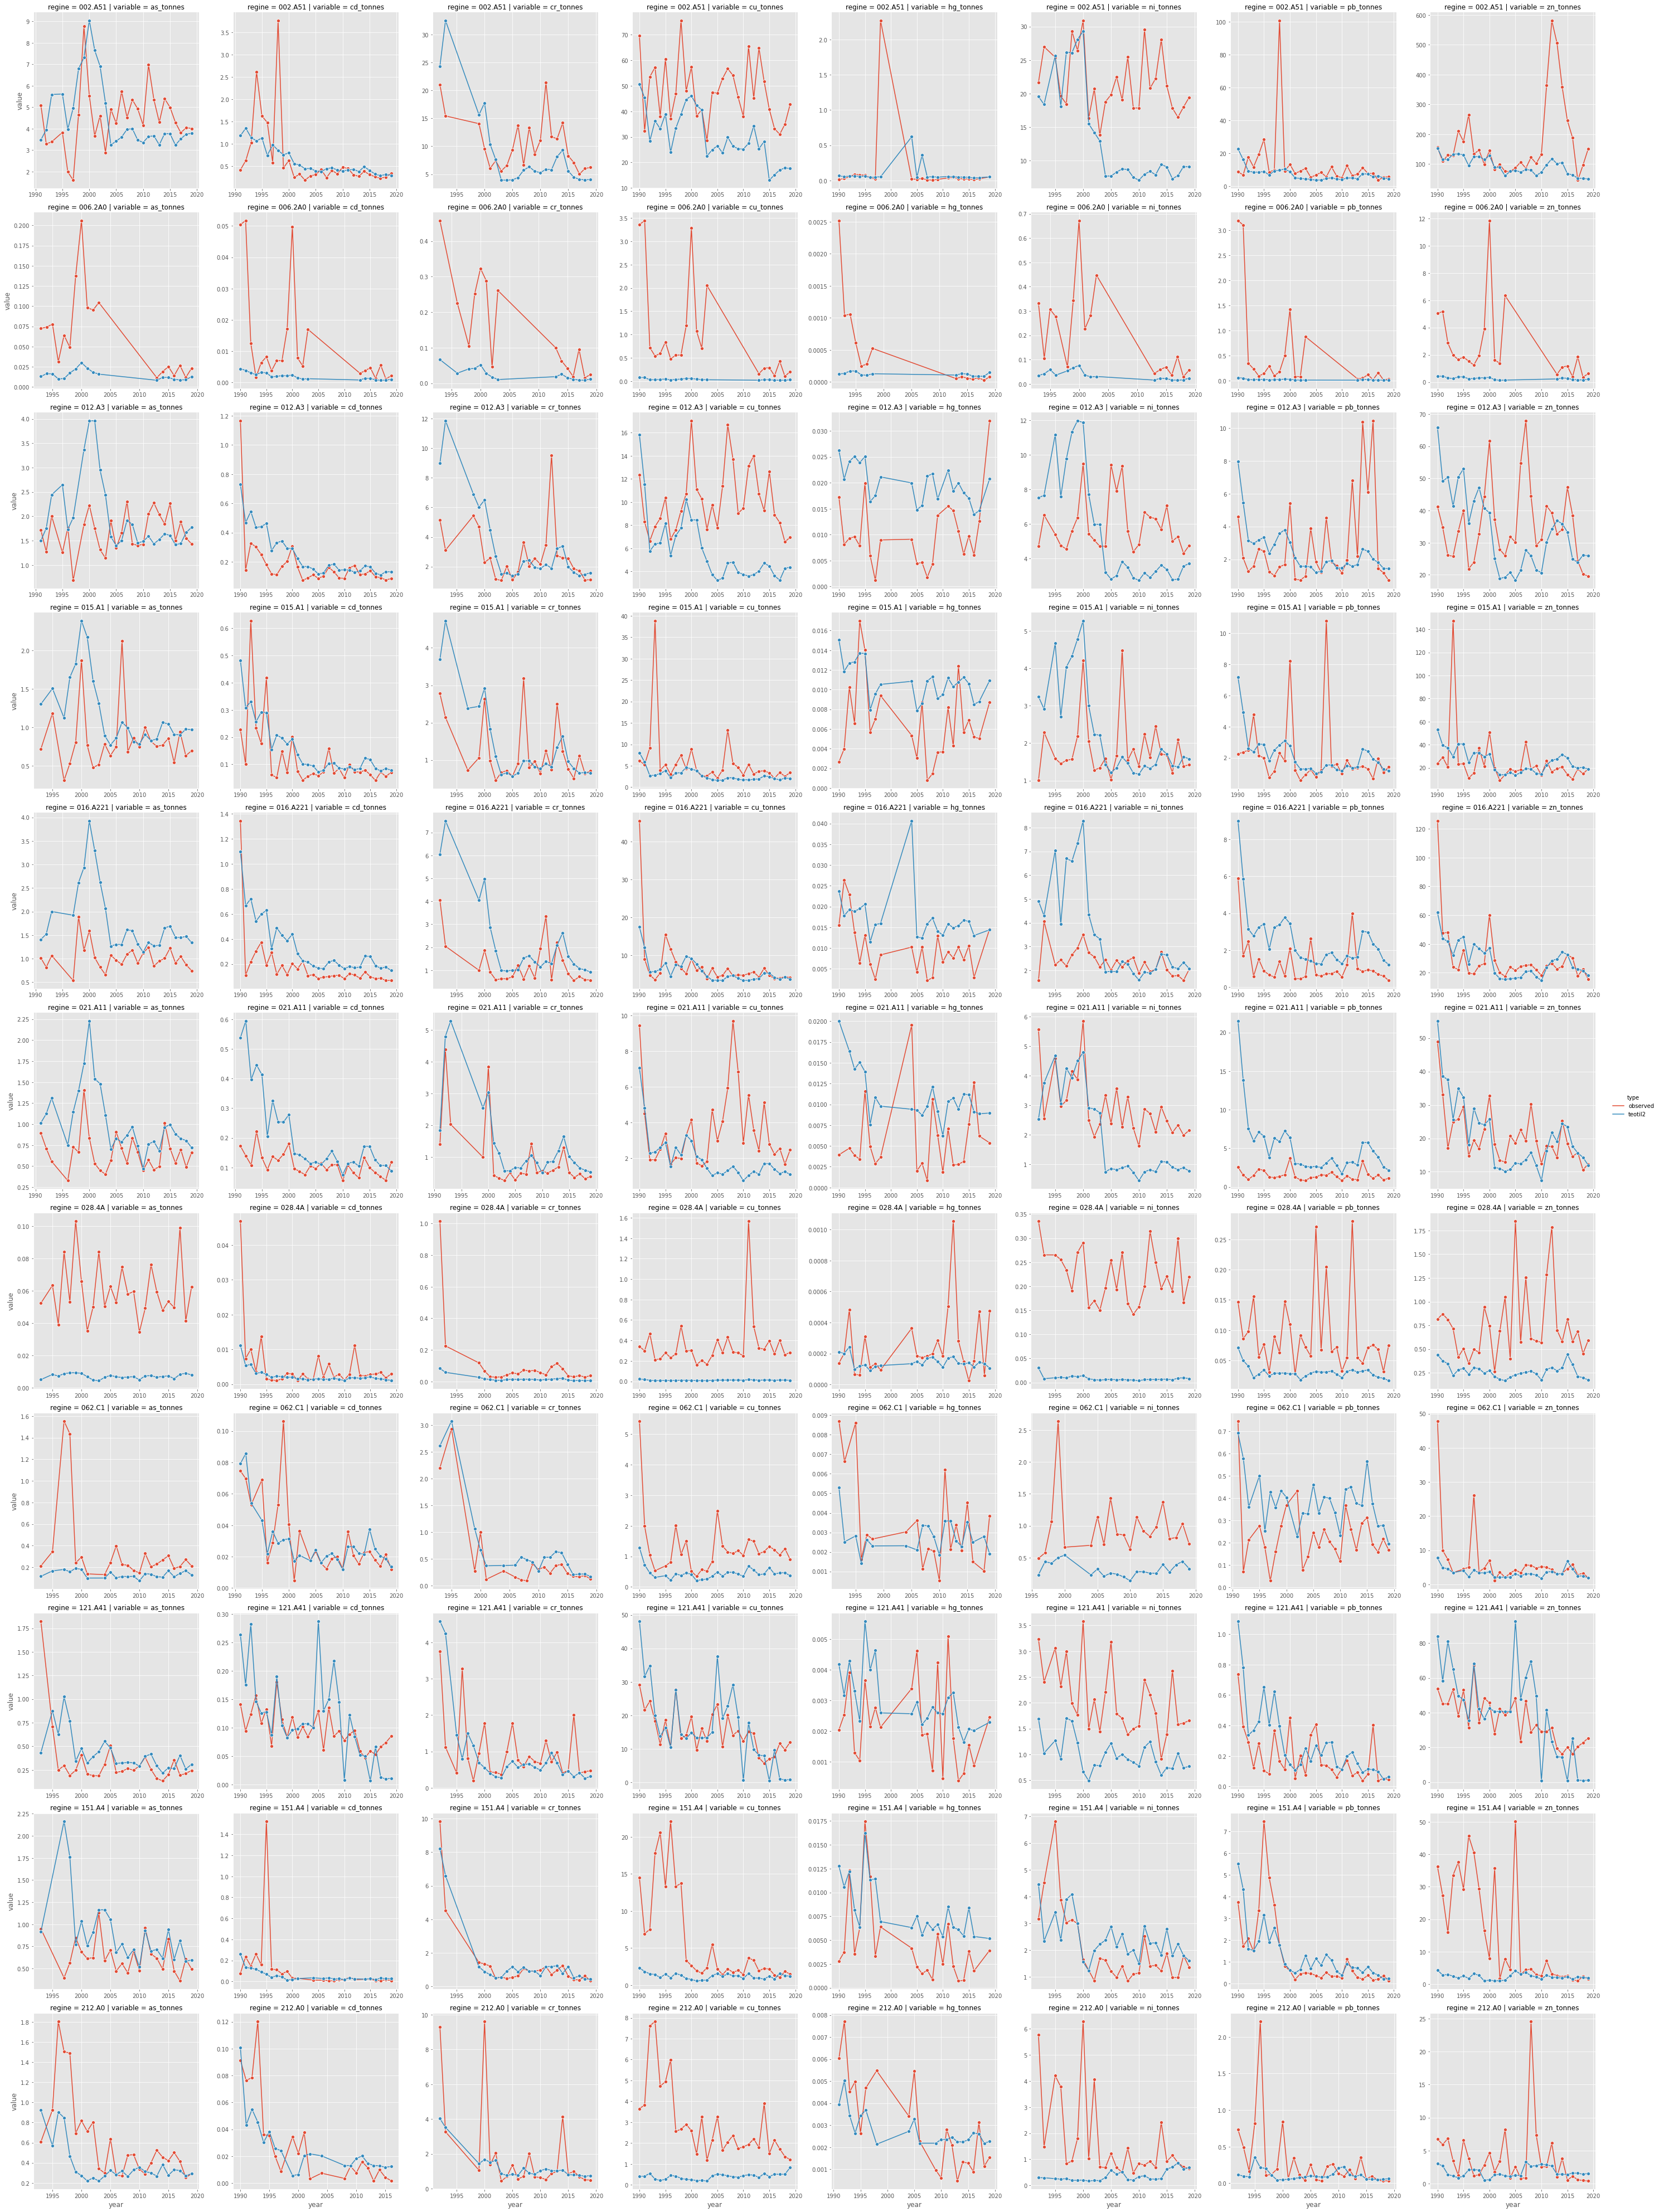

In [7]:
# Plot time series
g = sn.relplot(
    data=df,
    x="year",
    y="value",
    col="variable",
    row="regine",
    hue="type",
    kind="line",
    marker='o',
    col_order=sorted(df['variable'].unique()),
    row_order=sorted(df['regine'].unique()),
    facet_kws={"sharex": False, "sharey": False},
)

png_path = f'../plots/metals/results/mod_vs_obs_time_series_rid11_{st_yr}-{end_yr}.png'
plt.savefig(png_path, dpi=200, bbox_inches='tight')